In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Load the dataset
df = pd.read_csv("test.csv")
df

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,25971,78463,Male,disloyal Customer,34,Business travel,Business,526,3,3,...,4,3,2,4,4,5,4,0,0.0,neutral or dissatisfied
25972,25972,71167,Male,Loyal Customer,23,Business travel,Business,646,4,4,...,4,4,5,5,5,5,4,0,0.0,satisfied
25973,25973,37675,Female,Loyal Customer,17,Personal Travel,Eco,828,2,5,...,2,4,3,4,5,4,2,0,0.0,neutral or dissatisfied
25974,25974,90086,Male,Loyal Customer,14,Business travel,Business,1127,3,3,...,4,3,2,5,4,5,4,0,0.0,satisfied


In [21]:
# Data cleanup
# Impute missing values, encode categorical variables, and scale numerical variables
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns
categorical_features = (
    df.select_dtypes(include=["object"]).drop(["satisfaction"], axis=1).columns
)

# Create the preprocessing pipelines for both numerical and categorical data
numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Create column transformer that will allow us to preprocess all columns at once
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [22]:
# Apply transformation to the data
X = preprocessor.fit_transform(df)

# Dimensionality reduction using PCA
pca = PCA(n_components=0.95)  # keep 95% of variance
X_pca = pca.fit_transform(X)

In [23]:
# Choosing k for KMeans using the Elbow Method
# Fit multiple k-means models and store the values in an array
wcss = []
for i in range(1, 11):
    kmeans_pca = KMeans(
        n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=42
    )
    kmeans_pca.fit(X_pca)
    wcss.append(kmeans_pca.inertia_)

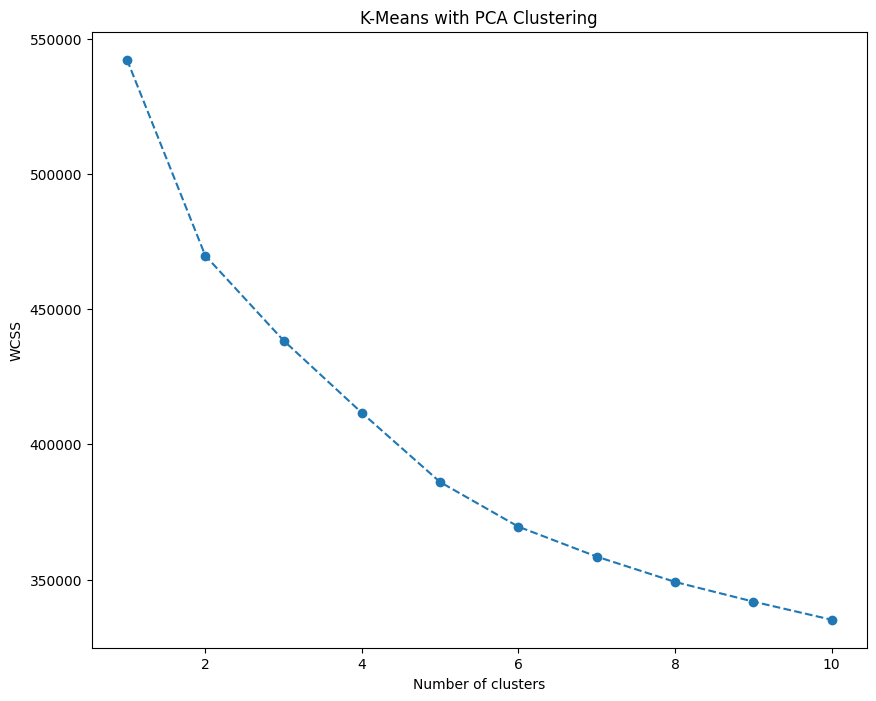

In [24]:
# Visualize the elbow method to find the optimal number of clusters
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss, marker="o", linestyle="--")
plt.title("K-Means with PCA Clustering")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [33]:
# Based on the plot, let's assume we choose k=4 (for example purposes)
k = 2
kmeans_pca = KMeans(
    n_clusters=k, init="k-means++", max_iter=300, n_init=10, random_state=42
)
kmeans_pca.fit(X_pca)

# Check silhouette score
silhouette_avg = silhouette_score(X_pca, kmeans_pca.labels_)
print(f"Silhouette Score for {k} clusters: {silhouette_avg:.2f}")

Silhouette Score for 2 clusters: 0.13


In [27]:
# After clustering with kmeans_pca
# Assign the cluster labels to the original dataframe 'df'
df["Cluster"] = kmeans_pca.labels_

# Prepare a dataframe with only numeric columns for summarizing
numeric_df = df.select_dtypes(include=[np.number])

# Add the cluster labels to this numeric dataframe
numeric_df["Cluster"] = df["Cluster"]

# Now group by cluster and calculate the mean only for numeric columns
cluster_summary = numeric_df.groupby("Cluster").mean()

# Print the summarized cluster characteristics
print(cluster_summary)

           Unnamed: 0            id        Age  Flight Distance  \
Cluster                                                           
0        13059.999170  62849.103812  37.831659       968.500457   
1        12924.854682  66869.100323  41.167061      1388.456046   

         Inflight wifi service  Departure/Arrival time convenient  \
Cluster                                                             
0                     2.306536                           2.943609   
1                     3.086114                           3.135989   

         Ease of Online booking  Gate location  Food and drink  \
Cluster                                                          
0                      2.498214       2.945270        2.452869   
1                      2.980194       3.004593        3.874202   

         Online boarding  Seat comfort  Inflight entertainment  \
Cluster                                                          
0               2.615896      2.588489                2.2

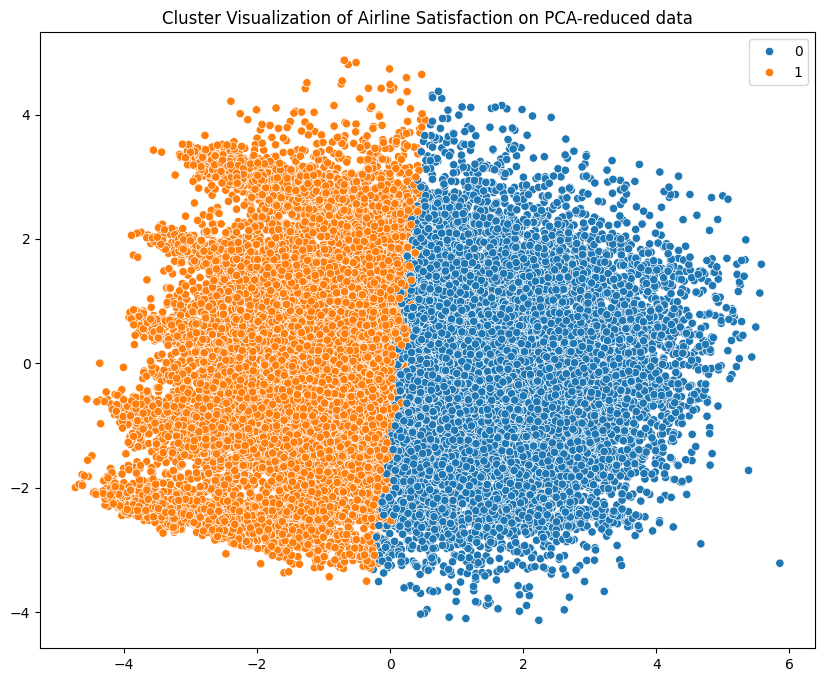

In [34]:
# Visualization of clusters
# Let's visualize just the first two principal components
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_pca.labels_)
plt.title("Cluster Visualization of Airline Satisfaction on PCA-reduced data")
plt.show()